In [33]:
# STEP 1: Initial setup and imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, FloatSlider, IntSlider, Layout, Button, HBox, VBox, Output
import ipywidgets as widgets

# Set the working directory
os.chdir('/Users/anthonymccrovitz/Desktop/Sphery/Sphere Heart Rate Analysis')

# Add scripts directory to path
sys.path.append('scripts')

# Import TCX parser
from parse_tcx import parse_tcx_to_df

# Load the data
print("Loading User 66 TCX data...")
try:
    df, session_total_sec, sessions_avg_hr, session_max_hr, calories_burned = parse_tcx_to_df('data/66-d.tcx')
    session_duration_min = session_total_sec / 60
    print(f"Data loaded successfully: {len(df)} data points over {session_duration_min:.2f} minutes")
    print(f"Average HR: {sessions_avg_hr:.1f} bpm, Maximum HR: {session_max_hr} bpm, Calories: {calories_burned}")
except Exception as e:
    print(f"Error loading data: {e}")
    
# Load the background image
try:
    img = mpimg.imread('charts_cropped/user_66.png')
    print("Background image loaded successfully")
except Exception as e:
    print(f"Error loading background image: {e}")

Loading User 66 TCX data...
Data loaded successfully: 213 data points over 44.80 minutes
Average HR: 144.8 bpm, Maximum HR: 182 bpm
Background image loaded successfully


In [34]:
# Create output directories for plots
import os
plots_dir = f'output/plots/user_66'
os.makedirs(plots_dir, exist_ok=True)
print(f"Created plots directory: {plots_dir}")

# Initialize global alignment parameters
# These will be updated by the interactive alignment tool
current_x_offset = -0.5  # Based on your most recent setting
current_x_scale = 1.0
current_y_min = 90
current_y_max = 185
current_alpha = 0.6


Created plots directory: output/plots/user_66


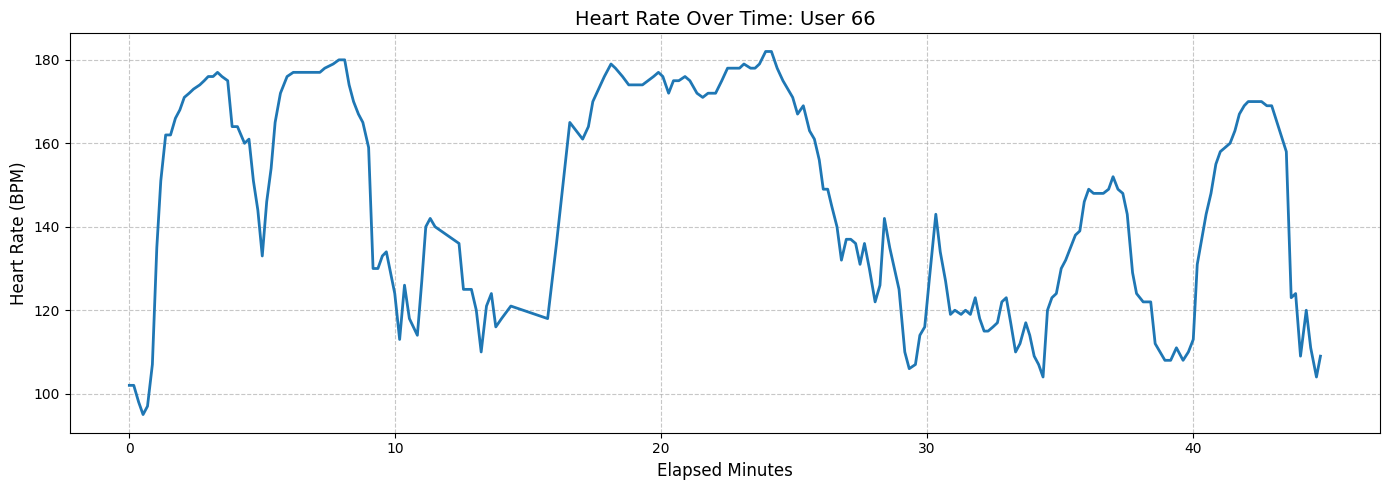

Maximum Heart Rate Details:
                    timestamp  heart_rate                start_time  \
103 2025-04-06 10:57:19+00:00         182 2025-04-06 10:33:23+00:00   
104 2025-04-06 10:57:32+00:00         182 2025-04-06 10:33:23+00:00   

     elapsed_min  
103    23.933333  
104    24.150000  


In [35]:
# STEP 2: Visualize the heart rate data
plt.figure(figsize=(14,5))
plt.plot(df['elapsed_min'], df['heart_rate'], linewidth=2)
plt.xlabel('Elapsed Minutes', fontsize=12)
plt.ylabel('Heart Rate (BPM)', fontsize=12)
plt.title('Heart Rate Over Time: User 66', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# Save the plot
plt.savefig(f'{plots_dir}/heart_rate_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# Show max heart rate point
max_hr_row = df[df['heart_rate'] == df['heart_rate'].max()]
print("Maximum Heart Rate Details:")
print(max_hr_row)

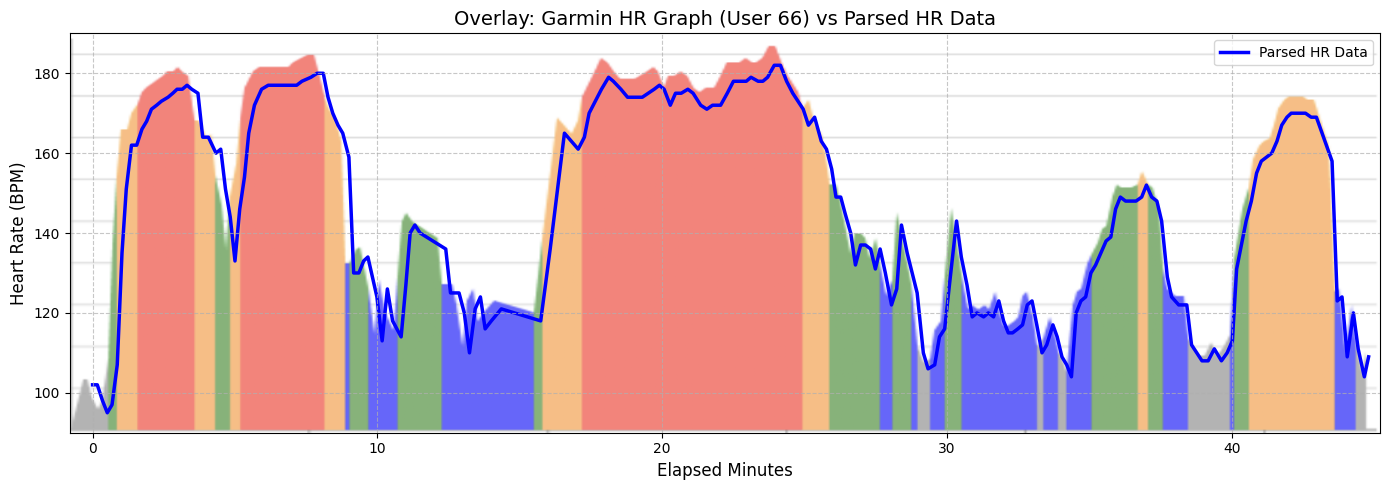

In [36]:
# STEP 3: Align heart rate data with Garmin graph
fig, ax = plt.subplots(figsize=(14,5))

# Initial alignment parameters
x_offset = -0.8  # Adjust left/right alignment
x_scale = 1.0    # Adjust width scaling
y_min = 90       # Set minimum heart rate
y_max = 190      # Set maximum heart rate
alpha = 0.6      # Background image opacity

# Calculate extent
x_min = x_offset
x_max = x_offset + (session_duration_min * x_scale) + 1.2

# Create overlay
ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
          alpha=alpha, zorder=0, interpolation='bilinear')
ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
        linewidth=2.5, label='Parsed HR Data', zorder=1)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('Elapsed Minutes', fontsize=12)
ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
ax.set_title('Overlay: Garmin HR Graph (User 66) vs Parsed HR Data', fontsize=14)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [37]:
# STEP 4: Interactive alignment tool
# Create a completely new implementation of the interactive tool

# Create sliders
x_offset_slider = FloatSlider(min=-5, max=5, step=0.1, value=-0.8, description='X Offset:', layout=Layout(width='500px'))
x_scale_slider = FloatSlider(min=0.5, max=1.5, step=0.01, value=1.0, description='X Scale:', layout=Layout(width='500px'))
y_min_slider = IntSlider(min=0, max=100, step=5, value=90, description='Y Min:', layout=Layout(width='500px'))
y_max_slider = IntSlider(min=150, max=250, step=5, value=190, description='Y Max:', layout=Layout(width='500px'))
alpha_slider = FloatSlider(min=0.1, max=1.0, step=0.05, value=0.6, description='Opacity:', layout=Layout(width='500px'))

# Create output for displaying the plot
plot_output = Output()

# Function to update the plot
def update_plot(b):
    global current_x_offset, current_x_scale, current_y_min, current_y_max, current_alpha
    
    # Get values from sliders
    x_offset = x_offset_slider.value
    x_scale = x_scale_slider.value
    y_min = y_min_slider.value
    y_max = y_max_slider.value
    alpha = alpha_slider.value
    
    # Update global variables
    current_x_offset = x_offset
    current_x_scale = x_scale
    current_y_min = y_min
    current_y_max = y_max
    current_alpha = alpha
    
    with plot_output:
        plot_output.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(14,5))
        
        # Calculate extent
        x_min = x_offset
        x_max = x_offset + (session_duration_min * x_scale) + 1.2
        
        # Display with current parameters
        ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
                alpha=alpha, zorder=0, interpolation='bilinear')
        
        ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
                linewidth=2.5, label='Parsed HR Data', zorder=1)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlabel('Elapsed Minutes', fontsize=12)
        ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
        ax.set_title(f'Alignment Parameters: x_offset={x_offset}, x_scale={x_scale}, y_range={y_min}-{y_max}', fontsize=12)
        ax.legend(loc='upper right')
        
        plt.tight_layout()
        # Save the plot
        plt.savefig(f'{plots_dir}/aligned_hr_data.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    print(f"Current settings: x_offset={x_offset}, x_scale={x_scale}, y_min={y_min}, y_max={y_max}, alpha={alpha}")
    print("Use these values in your final visualization")

# Create update button
update_button = Button(
    description='Update Visualization',
    button_style='primary',
    layout=Layout(width='200px')
)
update_button.on_click(update_plot)

# Create the UI layout
ui = VBox([
    HBox([x_offset_slider, x_scale_slider]),
    HBox([y_min_slider, y_max_slider, alpha_slider]),
    update_button,
    plot_output
])

# Display the UI
display(ui)

# Initial plot
update_plot(None)


Current settings: x_offset=-0.8, x_scale=1.0, y_min=90, y_max=190, alpha=0.6
Use these values in your final visualization


Current settings: x_offset=-0.7000000000000002, x_scale=1.0, y_min=90, y_max=185, alpha=0.6
Use these values in your final visualization


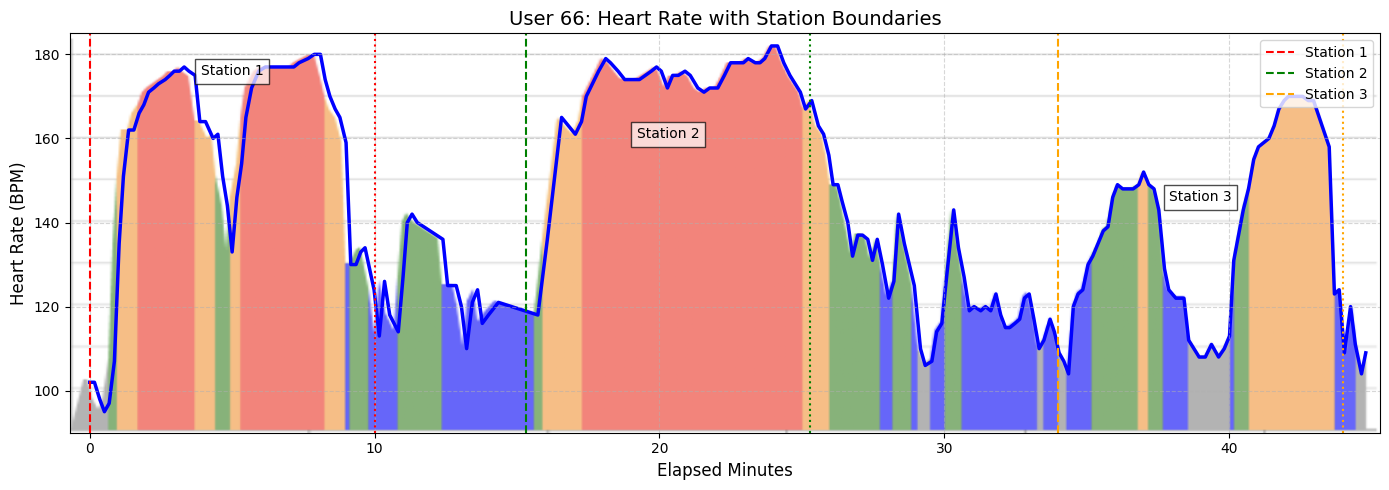

In [38]:
# STEP 5: Define station cutoffs
# Define initial station cutoffs based on visual inspection
cutoffs = [
    (0.0, 10.0),   # Station 1: after briefing/warmup
    (15.3, 25.3),  # Station 2
    (34.0, 44.0),  # Station 3
]

# Function to visualize stations with current cutoffs
def visualize_with_stations(x_offset=None, x_scale=None, y_min=None, y_max=None, alpha=None, cutoffs=None):
    # Use stored alignment parameters if not specified
    global current_x_offset, current_x_scale, current_y_min, current_y_max, current_alpha
    x_offset = current_x_offset if x_offset is None else x_offset
    x_scale = current_x_scale if x_scale is None else x_scale
    y_min = current_y_min if y_min is None else y_min
    y_max = current_y_max if y_max is None else y_max
    alpha = current_alpha if alpha is None else alpha
    # Use provided cutoffs or global cutoffs
    if cutoffs is None:
        cutoffs = globals()['cutoffs']
        
    fig, ax = plt.subplots(figsize=(14,5))
    
    # Calculate extent
    x_min = x_offset
    x_max = x_offset + (session_duration_min * x_scale) + 1.2
    
    # Display background image
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    
    # Plot HR data
    ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
            linewidth=2.5, label='Parsed HR Data', zorder=1)
    
    # Add vertical lines for station boundaries
    colors = ['red', 'green', 'orange']
    for i, (start, end) in enumerate(cutoffs):
        ax.axvline(x=start, color=colors[i % len(colors)], linestyle='--', 
                   label=f'Station {i+1} Start')
        ax.axvline(x=end, color=colors[i % len(colors)], linestyle=':',
                   label=f'Station {i+1} End')
        
        # Add station labels
        y_pos = y_max - 10 - (i * 15)
        ax.text((start + end)/2, y_pos, f'Station {i+1}', 
                horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.7))
    
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title('User 66: Heart Rate with Station Boundaries', fontsize=14)
    
    # Create a custom legend for station markers
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=colors[i % len(colors)], linestyle='--') 
                    for i in range(len(cutoffs))]
    ax.legend(custom_lines, [f'Station {i+1}' for i in range(len(cutoffs))], 
              loc='upper right')
    
    plt.tight_layout()
        # Save the plot
        plt.savefig(f'{plots_dir}/heart_rate_with_stations.png', dpi=300, bbox_inches='tight')
        plt.show()

# Show initial station boundaries
visualize_with_stations()


In [39]:
# STEP 6: Interactive station boundary adjustment
out = Output()

def station_cutoff_adjuster():
    global cutoffs
    
    # Create sliders for each station boundary
    sliders = []
    for i, (start, end) in enumerate(cutoffs):
        start_slider = FloatSlider(
            value=start,
            min=0,
            max=session_duration_min,
            step=0.1,
            description=f'Station {i+1} Start:',
            style={'description_width': '120px'},
            layout=Layout(width='500px')
        )
        
        end_slider = FloatSlider(
            value=end,
            min=0,
            max=session_duration_min,
            step=0.1,
            description=f'Station {i+1} End:',
            style={'description_width': '120px'},
            layout=Layout(width='500px')
        )
        
        sliders.extend([start_slider, end_slider])
    
    # Update button
    update_btn = Button(
        description='Update Visualization',
        button_style='primary',
        layout=Layout(width='200px')
    )
    
    # Apply button
    apply_btn = Button(
        description='Apply Changes',
        button_style='success',
        layout=Layout(width='200px')
    )
    
    # Create UI layout
    ui = VBox([HBox([update_btn, apply_btn])] + 
              [HBox([sliders[i*2], sliders[i*2+1]]) for i in range(len(cutoffs))])
    
    # Define button actions
    def on_update_clicked(b):
        with out:
            out.clear_output()
            # Update cutoffs from sliders
            new_cutoffs = []
            for i in range(len(cutoffs)):
                start = sliders[i*2].value
                end = sliders[i*2+1].value
                new_cutoffs.append((start, end))
            
            # Visualize with new cutoffs
            visualize_with_stations(cutoffs=new_cutoffs)
            print("Preview of new station boundaries (not yet applied)")
    
    def on_apply_clicked(b):
        with out:
            out.clear_output()
            # Update global cutoffs
            global cutoffs
            new_cutoffs = []
            for i in range(len(cutoffs)):
                start = sliders[i*2].value
                end = sliders[i*2+1].value
                new_cutoffs.append((start, end))
            
            cutoffs = new_cutoffs
            print("Station boundaries updated to:")
            for i, (start, end) in enumerate(cutoffs, 1):
                print(f"Station {i}: {start:.1f} - {end:.1f} minutes")
            
            # Process station data with new cutoffs
            process_station_data()
    
    update_btn.on_click(on_update_clicked)
    apply_btn.on_click(on_apply_clicked)
    
    display(ui)
    display(out)

# Process station data based on current cutoffs
def process_station_data():
    station_rows = []
    
    for i, (start_min, end_min) in enumerate(cutoffs, 1):
        # For station 3, ensure we use the full range to the end of the session
        if i == 3:
            segment = df[(df['elapsed_min'] >= start_min)]
        else:
            # For other stations, use the defined cutoffs
            segment = df[(df['elapsed_min'] >= start_min) & (df['elapsed_min'] <= end_min)]
        
        if segment.empty:
            print(f"Warning: No data found for Station {i}")
            continue
        
        # Debug information to verify station duration calculation
        actual_duration = (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60
        cutoff_duration = end_min - start_min
        print(f"Station {i} - Cutoff duration: {cutoff_duration:.2f} min, Actual data duration: {actual_duration:.2f} min")
        print(f"  First point: {segment['elapsed_min'].iloc[0]:.2f} min, Last point: {segment['elapsed_min'].iloc[-1]:.2f} min")
            
        # Calculate the exact duration from the timestamp difference for all stations
        station_duration = (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60
        if i == 3:
            print(f"  Station {i} exact duration: {station_duration:.2f} minutes")
            
        station_row = {
            # User and session info
            'user_id': 66,
            'gender': 'NA',
            'circuit_type': 'NA',
            
            # Station info
            'station_number': i,
            'station_name': 'NA',
            
            # Session timing and HR data
            'session_start_time': df['timestamp'].iloc[0],
            'session_end_time': df['timestamp'].iloc[-1],
            'session_duration_min': session_duration_min,
            'session_avg_hr': sessions_avg_hr,
            'session_max_hr': session_max_hr,
            
            # Station timing and HR data
            'station_start_time': segment['timestamp'].iloc[0],
            'station_end_time': segment['timestamp'].iloc[-1],
            'station_duration_min': station_duration,
            'station_avg_hr': segment['heart_rate'].mean(),
            'station_max_hr': segment['heart_rate'].max(),
            
            # Per-station ratings
            'motivation': 'NA',  # 1-5 scale
            'enjoyment': 'NA',   # 1-5 scale (previously 'fun')
            'team_experience': 'NA',  # 1-5 scale (only for exergame duos)
            'subjective_physical_exertion': 'NA',  # Borg RPE 1-10 scale
            'subjective_cognitive_exertion': 'NA',  # 1-5 scale
            
            # Final evaluation (same for all stations of a user)
            'overall_experience': 'NA',  # 1-5 scale
            'overall_motivation': 'NA',  # 1-5 scale
            'feedback': 'NA',  # Free text
            
            # Additional data
            'sports_exp': 'NA',
            'gaming_exp': 'NA',
            'data_quality': 'Good',
            'notes': ''
        }
        station_rows.append(station_row)
    
    # Create and display DataFrame
    station_df = pd.DataFrame(station_rows)
    display(station_df)
    
    # Return the DataFrame for further use
    return station_df

# Call the interactive adjuster
station_cutoff_adjuster()


Output()

In [40]:
# STEP 7: Save processed data to CSV

# Copy the process_station_data function here to ensure it's available
def process_station_data():
    station_rows = []
    
    for i, (start_min, end_min) in enumerate(cutoffs, 1):
        # For station 3, ensure we use the full range to the end of the session
        if i == 3:
            segment = df[(df['elapsed_min'] >= start_min)]
        else:
            # For other stations, use the defined cutoffs
            segment = df[(df['elapsed_min'] >= start_min) & (df['elapsed_min'] <= end_min)]
        
        if segment.empty:
            print(f"Warning: No data found for Station {i}")
            continue
        
        # Debug information to verify station duration calculation
        actual_duration = (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60
        cutoff_duration = end_min - start_min
        print(f"Station {i} - Cutoff duration: {cutoff_duration:.2f} min, Actual data duration: {actual_duration:.2f} min")
        print(f"  First point: {segment['elapsed_min'].iloc[0]:.2f} min, Last point: {segment['elapsed_min'].iloc[-1]:.2f} min")
            
        # Calculate the exact duration from the timestamp difference for all stations
        station_duration = (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60
        if i == 3:
            print(f"  Station {i} exact duration: {station_duration:.2f} minutes")
            
        station_row = {
            # User and session info
            'user_id': 66,
            'gender': 'NA',
            'circuit_type': 'NA',
            
            # Station info
            'station_number': i,
            'station_name': 'NA',
            
            # Session timing and HR data
            'session_start_time': df['timestamp'].iloc[0],
            'session_end_time': df['timestamp'].iloc[-1],
            'session_duration_min': session_duration_min,
            'session_avg_hr': sessions_avg_hr,
            'session_max_hr': session_max_hr,
            
            # Station timing and HR data
            'station_start_time': segment['timestamp'].iloc[0],
            'station_end_time': segment['timestamp'].iloc[-1],
            'station_duration_min': station_duration,
            'station_avg_hr': segment['heart_rate'].mean(),
            'station_max_hr': segment['heart_rate'].max(),
            
            # Per-station ratings
            'motivation': 'NA',  # 1-5 scale
            'enjoyment': 'NA',   # 1-5 scale (previously 'fun')
            'team_experience': 'NA',  # 1-5 scale (only for exergame duos)
            'subjective_physical_exertion': 'NA',  # Borg RPE 1-10 scale
            'subjective_cognitive_exertion': 'NA',  # 1-5 scale
            
            # Final evaluation (same for all stations of a user)
            'overall_experience': 'NA',  # 1-5 scale
            'overall_motivation': 'NA',  # 1-5 scale
            'feedback': 'NA',  # Free text
            
            # Additional data
            'sports_exp': 'NA',
            'gaming_exp': 'NA',
            'data_quality': 'Good',
            'notes': ''
        }
        station_rows.append(station_row)
    
    # Create and display DataFrame
    station_df = pd.DataFrame(station_rows)
    display(station_df)
    
    # Return the DataFrame for further use
    return station_df

# Function to save station data to CSV
def save_station_data():
    # Get the latest station data using the local process_station_data function
    station_df = process_station_data()
    
    # Save to CSV
    output_path = 'output/processed/user_66_station_data.csv'
    station_df.to_csv(output_path, index=False)
    print(f"Station data saved to: {output_path}")
    
    return station_df

# Create a button to save data
save_button = Button(
    description='Save Station Data',
    button_style='success',
    layout=Layout(width='200px')
)

save_output = Output()

def on_save_clicked(b):
    with save_output:
        save_output.clear_output()
        save_station_data()

save_button.on_click(on_save_clicked)

display(save_button)
display(save_output)


Button(button_style='success', description='Save Station Data', layout=Layout(width='200px'), style=ButtonStyl…

Output()

In [41]:
# Display full DataFrame for inspection
# This will show all columns and rows without truncation

# Copy the process_station_data function here to ensure it's available
def process_station_data():
    station_rows = []
    
    for i, (start_min, end_min) in enumerate(cutoffs, 1):
        # For station 3, ensure we use the full range to the end of the session
        if i == 3:
            segment = df[(df['elapsed_min'] >= start_min)]
        else:
            # For other stations, use the defined cutoffs
            segment = df[(df['elapsed_min'] >= start_min) & (df['elapsed_min'] <= end_min)]
        
        if segment.empty:
            print(f"Warning: No data found for Station {i}")
            continue
        
        # Debug information to verify station duration calculation
        actual_duration = (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60
        cutoff_duration = end_min - start_min
        print(f"Station {i} - Cutoff duration: {cutoff_duration:.2f} min, Actual data duration: {actual_duration:.2f} min")
        print(f"  First point: {segment['elapsed_min'].iloc[0]:.2f} min, Last point: {segment['elapsed_min'].iloc[-1]:.2f} min")
            
        # Calculate the exact duration from the timestamp difference for all stations
        station_duration = (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60
        if i == 3:
            print(f"  Station {i} exact duration: {station_duration:.2f} minutes")
            
        station_row = {
            # User and session info
            'user_id': 66,
            'gender': 'NA',
            'circuit_type': 'NA',
            
            # Station info
            'station_number': i,
            'station_name': 'NA',
            
            # Session timing and HR data
            'session_start_time': df['timestamp'].iloc[0],
            'session_end_time': df['timestamp'].iloc[-1],
            'session_duration_min': session_duration_min,
            'session_avg_hr': sessions_avg_hr,
            'session_max_hr': session_max_hr,
            
            # Station timing and HR data
            'station_start_time': segment['timestamp'].iloc[0],
            'station_end_time': segment['timestamp'].iloc[-1],
            'station_duration_min': station_duration,
            'station_avg_hr': segment['heart_rate'].mean(),
            'station_max_hr': segment['heart_rate'].max(),
            
            # Per-station ratings
            'motivation': 'NA',  # 1-5 scale
            'enjoyment': 'NA',   # 1-5 scale (previously 'fun')
            'team_experience': 'NA',  # 1-5 scale (only for exergame duos)
            'subjective_physical_exertion': 'NA',  # Borg RPE 1-10 scale
            'subjective_cognitive_exertion': 'NA',  # 1-5 scale
            
            # Final evaluation (same for all stations of a user)
            'overall_experience': 'NA',  # 1-5 scale
            'overall_motivation': 'NA',  # 1-5 scale
            'feedback': 'NA',  # Free text
            
            # Additional data
            'sports_exp': 'NA',
            'gaming_exp': 'NA',
            'data_quality': 'Good',
            'notes': ''
        }
        station_rows.append(station_row)
    
    # Create and display DataFrame
    station_df = pd.DataFrame(station_rows)
    display(station_df)
    
    # Return the DataFrame for further use
    return station_df

# First, get the latest processed data
inspection_df = process_station_data()

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Wide display
pd.set_option('display.max_colwidth', None)  # Don't truncate column contents

# Print the full DataFrame
print("\n===== FULL DATAFRAME INSPECTION =====\n")
print(inspection_df)
print("\n===== END OF DATAFRAME =====\n")

# Show DataFrame info (types and non-null values)
print("\n===== DATAFRAME INFO =====\n")
inspection_df.info()

# Show DataFrame statistics
print("\n===== DATAFRAME STATISTICS =====\n")
print(inspection_df.describe())

# Reset display options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


Station 1 - Cutoff duration: 10.00 min, Actual data duration: 9.98 min
  First point: 0.00 min, Last point: 9.98 min
Station 2 - Cutoff duration: 10.00 min, Actual data duration: 9.40 min
  First point: 15.73 min, Last point: 25.13 min
Station 3 - Cutoff duration: 10.00 min, Actual data duration: 10.77 min
  First point: 34.03 min, Last point: 44.80 min
  Station 3 exact duration: 10.77 minutes


,user_id,gender,circuit_type,station_number,station_name,session_start_time,session_end_time,session_duration_min,session_avg_hr,session_max_hr,...,team_experience,subjective_physical_exertion,subjective_cognitive_exertion,overall_experience,overall_motivation,feedback,sports_exp,gaming_exp,data_quality,notes
0,66,NA,NA,1,NA,2025-04-06 10:33:23+00:00,2025-04-06 11:18:11+00:00,44.8,144.760563,182,...,NA,NA,NA,NA,NA,NA,NA,NA,Good,
1,66,NA,NA,2,NA,2025-04-06 10:33:23+00:00,2025-04-06 11:18:11+00:00,44.8,144.760563,182,...,NA,NA,NA,NA,NA,NA,NA,NA,Good,
2,66,NA,NA,3,NA,2025-04-06 10:33:23+00:00,2025-04-06 11:18:11+00:00,44.8,144.760563,182,...,NA,NA,NA,NA,NA,NA,NA,NA,Good,



===== FULL DATAFRAME INSPECTION =====

   user_id gender circuit_type  station_number station_name        session_start_time          session_end_time  session_duration_min  session_avg_hr  session_max_hr        station_start_time          station_end_time  station_duration_min  station_avg_hr  station_max_hr motivation enjoyment team_experience subjective_physical_exertion subjective_cognitive_exertion overall_experience overall_motivation feedback sports_exp gaming_exp data_quality notes
0       66     NA           NA               1           NA 2025-04-06 10:33:23+00:00 2025-04-06 11:18:11+00:00                  44.8      144.760563             182 2025-04-06 10:33:23+00:00 2025-04-06 10:43:22+00:00              9.983333      155.596154             180         NA        NA              NA                           NA                            NA                 NA                 NA       NA         NA         NA         Good      
1       66     NA           NA               2  

In [42]:
# Preview how the CSV will look
# This cell will show the raw CSV content without actually saving the file

import io

# Copy the process_station_data function here to ensure it's available
def process_station_data():
    station_rows = []
    
    for i, (start_min, end_min) in enumerate(cutoffs, 1):
        # For station 3, ensure we use the full range to the end of the session
        if i == 3:
            segment = df[(df['elapsed_min'] >= start_min)]
        else:
            # For other stations, use the defined cutoffs
            segment = df[(df['elapsed_min'] >= start_min) & (df['elapsed_min'] <= end_min)]
        
        if segment.empty:
            print(f"Warning: No data found for Station {i}")
            continue
        
        # Debug information to verify station duration calculation
        actual_duration = (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60
        cutoff_duration = end_min - start_min
        print(f"Station {i} - Cutoff duration: {cutoff_duration:.2f} min, Actual data duration: {actual_duration:.2f} min")
        print(f"  First point: {segment['elapsed_min'].iloc[0]:.2f} min, Last point: {segment['elapsed_min'].iloc[-1]:.2f} min")
            
        # Calculate the exact duration from the timestamp difference for all stations
        station_duration = (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60
        if i == 3:
            print(f"  Station {i} exact duration: {station_duration:.2f} minutes")
            
        station_row = {
            # User and session info
            'user_id': 66,
            'gender': 'NA',
            'circuit_type': 'NA',
            
            # Station info
            
            # User metadata
            'age': age,
            'gender': gender,
            'height_cm': height_cm,
            'weight_kg': weight_kg,
            'champ_number': champ_number,
            'calories_burned': calories_burned,
            
            'station_number': i,
            'station_name': 'NA',
            
            # Session timing and HR data
            'session_start_time': df['timestamp'].iloc[0],
            'session_end_time': df['timestamp'].iloc[-1],
            'session_duration_min': session_duration_min,
            'session_avg_hr': sessions_avg_hr,
            'session_max_hr': session_max_hr,
            
            # Station timing and HR data
            'station_start_time': segment['timestamp'].iloc[0],
            'station_end_time': segment['timestamp'].iloc[-1],
            'station_duration_min': station_duration,
            'station_avg_hr': segment['heart_rate'].mean(),
            'station_max_hr': segment['heart_rate'].max(),
            
            # Per-station ratings
            'motivation': 'NA',  # 1-5 scale
            'enjoyment': 'NA',   # 1-5 scale (previously 'fun')
            'team_experience': 'NA',  # 1-5 scale (only for exergame duos)
            'subjective_physical_exertion': 'NA',  # Borg RPE 1-10 scale
            'subjective_cognitive_exertion': 'NA',  # 1-5 scale
            
            # Final evaluation (same for all stations of a user)
            'overall_experience': 'NA',  # 1-5 scale
            'overall_motivation': 'NA',  # 1-5 scale
            'feedback': 'NA',  # Free text
            
            # Additional data
            'sports_exp': 'NA',
            'gaming_exp': 'NA',
            'data_quality': 'Good',
            'notes': ''
        }
        station_rows.append(station_row)
    
    # Create and display DataFrame
    station_df = pd.DataFrame(station_rows)
    display(station_df)
    
    # Return the DataFrame for further use
    return station_df

# Get the latest processed data
csv_preview_df = process_station_data()

# Create a string buffer and write the CSV to it
buffer = io.StringIO()
csv_preview_df.to_csv(buffer, index=False)

# Reset the buffer position to the beginning
buffer.seek(0)

# Read and print the CSV content
csv_content = buffer.getvalue()
print("===== CSV PREVIEW =====")
print(csv_content)
print("===== END OF CSV PREVIEW =====")

# Check for potential issues in the CSV
print("\n===== CSV VALIDATION =====")
print(f"Number of rows: {len(csv_preview_df)}")
print(f"Number of columns: {len(csv_preview_df.columns)}")

# Check for missing values
missing_values = csv_preview_df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")
if missing_values > 0:
    print("Columns with missing values:")
    print(csv_preview_df.isnull().sum()[csv_preview_df.isnull().sum() > 0])

# Check for potential delimiter issues in string columns
for col in csv_preview_df.select_dtypes(include=['object']).columns:
    if csv_preview_df[col].str.contains(',').any():
        print(f"Warning: Column '{col}' contains commas which might cause CSV parsing issues")


Station 1 - Cutoff duration: 10.00 min, Actual data duration: 9.98 min
  First point: 0.00 min, Last point: 9.98 min
Station 2 - Cutoff duration: 10.00 min, Actual data duration: 9.40 min
  First point: 15.73 min, Last point: 25.13 min
Station 3 - Cutoff duration: 10.00 min, Actual data duration: 10.77 min
  First point: 34.03 min, Last point: 44.80 min
  Station 3 exact duration: 10.77 minutes


,user_id,gender,circuit_type,station_number,station_name,session_start_time,session_end_time,session_duration_min,session_avg_hr,session_max_hr,...,team_experience,subjective_physical_exertion,subjective_cognitive_exertion,overall_experience,overall_motivation,feedback,sports_exp,gaming_exp,data_quality,notes
0,66,NA,NA,1,NA,2025-04-06 10:33:23+00:00,2025-04-06 11:18:11+00:00,44.8,144.760563,182,...,NA,NA,NA,NA,NA,NA,NA,NA,Good,
1,66,NA,NA,2,NA,2025-04-06 10:33:23+00:00,2025-04-06 11:18:11+00:00,44.8,144.760563,182,...,NA,NA,NA,NA,NA,NA,NA,NA,Good,
2,66,NA,NA,3,NA,2025-04-06 10:33:23+00:00,2025-04-06 11:18:11+00:00,44.8,144.760563,182,...,NA,NA,NA,NA,NA,NA,NA,NA,Good,


===== CSV PREVIEW =====
user_id,gender,circuit_type,station_number,station_name,session_start_time,session_end_time,session_duration_min,session_avg_hr,session_max_hr,station_start_time,station_end_time,station_duration_min,station_avg_hr,station_max_hr,motivation,enjoyment,team_experience,subjective_physical_exertion,subjective_cognitive_exertion,overall_experience,overall_motivation,feedback,sports_exp,gaming_exp,data_quality,notes
66,NA,NA,1,NA,2025-04-06 10:33:23+00:00,2025-04-06 11:18:11+00:00,44.8,144.7605633802817,182,2025-04-06 10:33:23+00:00,2025-04-06 10:43:22+00:00,9.983333333333333,155.59615384615384,180,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Good,
66,NA,NA,2,NA,2025-04-06 10:33:23+00:00,2025-04-06 11:18:11+00:00,44.8,144.7605633802817,182,2025-04-06 10:49:07+00:00,2025-04-06 10:58:31+00:00,9.4,172.10256410256412,182,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Good,
66,NA,NA,3,NA,2025-04-06 10:33:23+00:00,2025-04-06 11:18:11+00:00,44.8,144.7605633802817,182,2025-04-06 11:07:25+00:00,2025-04-06 11

In [ ]:
# Load user metadata
import pandas as pd
try:
    metadata_df = pd.read_csv('metadata/user_metadata.csv')
    user_meta = metadata_df[metadata_df['user_id'] == USER_ID]
    if not user_meta.empty:
        user_meta = user_meta.iloc[0]
        age = user_meta['age'] if not pd.isna(user_meta['age']) else None
        gender = user_meta['gender'] if not pd.isna(user_meta['gender']) else None
        height_cm = user_meta['height_cm'] if not pd.isna(user_meta['height_cm']) else None
        weight_kg = user_meta['weight_kg'] if not pd.isna(user_meta['weight_kg']) else None
        champ_number = user_meta['champ_number'] if not pd.isna(user_meta['champ_number']) else None
        print(f"Loaded metadata for user {USER_ID}: age={age}, gender={gender}, height={height_cm}cm, weight={weight_kg}kg, champ={champ_number}")
    else:
        print(f"No metadata found for user {USER_ID}")
        age = gender = height_cm = weight_kg = champ_number = None
except Exception as e:
    print(f"Error loading metadata: {e}")
    age = gender = height_cm = weight_kg = champ_number = None


In [ ]:
# Load user metadata
import pandas as pd
try:
    metadata_df = pd.read_csv('metadata/user_metadata.csv')
    user_meta = metadata_df[metadata_df['user_id'] == 66]
    if not user_meta.empty:
        user_meta = user_meta.iloc[0]
        age = user_meta['age'] if not pd.isna(user_meta['age']) else None
        gender = user_meta['gender'] if not pd.isna(user_meta['gender']) else None
        height_cm = user_meta['height_cm'] if not pd.isna(user_meta['height_cm']) else None
        weight_kg = user_meta['weight_kg'] if not pd.isna(user_meta['weight_kg']) else None
        champ_number = user_meta['champ_number'] if not pd.isna(user_meta['champ_number']) else None
        print(f"Loaded metadata for user {user_id}: age={age}, gender={gender}, height={height_cm}cm, weight={weight_kg}kg, champ={champ_number}")
    else:
        print(f"No metadata found for user {user_id}")
        age = gender = height_cm = weight_kg = champ_number = None
except Exception as e:
    print(f"Error loading metadata: {e}")
    age = gender = height_cm = weight_kg = champ_number = None


In [43]:
# Examine raw heart rate data to help determine station cutoffs
# This will show the full heart rate data with timestamps and elapsed minutes

# Display the raw DataFrame with heart rate values
print("===== RAW HEART RATE DATA =====")
print("First 10 rows:")
print(df[['timestamp', 'elapsed_min', 'heart_rate']].head(10))
print("\nLast 10 rows:")
print(df[['timestamp', 'elapsed_min', 'heart_rate']].tail(10))

# Find high heart rate periods that might indicate stations
print("\n===== POTENTIAL STATION BOUNDARIES =====")
# Calculate rolling average to smooth the data
df['smooth_hr'] = df['heart_rate'].rolling(window=5, center=True).mean()

# Find significant changes in heart rate (potential station boundaries)
df['hr_change'] = df['smooth_hr'].diff().abs()
significant_changes = df[df['hr_change'] > 10].sort_values('hr_change', ascending=False).head(10)
print("Potential station boundaries (large heart rate changes):")
print(significant_changes[['timestamp', 'elapsed_min', 'heart_rate', 'hr_change']])

# Find periods of sustained high heart rate
high_hr_threshold = sessions_avg_hr + 10  # 10 BPM above average
high_hr_periods = df[df['heart_rate'] > high_hr_threshold]
print("\nHigh heart rate periods (potential stations):")
print(f"Threshold: {high_hr_threshold} BPM")

# Group consecutive high HR points to identify distinct periods
if not high_hr_periods.empty:
    # Find gaps in the high HR periods
    high_hr_periods['gap'] = high_hr_periods['elapsed_min'].diff() > 1.0
    high_hr_periods['period'] = high_hr_periods['gap'].cumsum()
    
    # Summarize each period
    period_summary = high_hr_periods.groupby('period').agg(
        start_time=('elapsed_min', 'min'),
        end_time=('elapsed_min', 'max'),
        duration=('elapsed_min', lambda x: x.max() - x.min()),
        avg_hr=('heart_rate', 'mean'),
        max_hr=('heart_rate', 'max')
    ).reset_index()
    
    # Filter to show only significant periods (longer than 1 minute)
    significant_periods = period_summary[period_summary['duration'] > 1.0]
    print("\nSignificant high heart rate periods (potential stations):")
    print(significant_periods[['start_time', 'end_time', 'duration', 'avg_hr', 'max_hr']])


===== RAW HEART RATE DATA =====
First 10 rows:
                  timestamp  elapsed_min  heart_rate
0 2025-04-06 10:33:23+00:00     0.000000         102
1 2025-04-06 10:33:33+00:00     0.166667         102
2 2025-04-06 10:33:44+00:00     0.350000          98
3 2025-04-06 10:33:54+00:00     0.516667          95
4 2025-04-06 10:34:04+00:00     0.683333          97
5 2025-04-06 10:34:15+00:00     0.866667         107
6 2025-04-06 10:34:25+00:00     1.033333         135
7 2025-04-06 10:34:34+00:00     1.183333         151
8 2025-04-06 10:34:45+00:00     1.366667         162
9 2025-04-06 10:34:56+00:00     1.550000         162

Last 10 rows:
                    timestamp  elapsed_min  heart_rate
203 2025-04-06 11:16:10+00:00    42.783333         169
204 2025-04-06 11:16:21+00:00    42.966667         169
205 2025-04-06 11:16:54+00:00    43.516667         158
206 2025-04-06 11:17:05+00:00    43.700000         123
207 2025-04-06 11:17:15+00:00    43.866667         124
208 2025-04-06 11:17:26+0

/var/folders/wn/kjhkcp0x4c94gmv1184_v4t00000gn/T/ipykernel_26824/1438865420.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_hr_periods['gap'] = high_hr_periods['elapsed_min'].diff() > 1.0
/var/folders/wn/kjhkcp0x4c94gmv1184_v4t00000gn/T/ipykernel_26824/1438865420.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_hr_periods['period'] = high_hr_periods['gap'].cumsum()
